In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Bahia - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_BA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Bahia - value,Bahia- custo m2 (R$),Bahia - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.299858,10915.348400,151.297,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.598394,0.766362,0.669899,39.798880,7.782609e+06,0.638715,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.301903,11028.218400,138.707,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.598795,0.766745,0.670210,39.480034,7.827094e+06,0.638948,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.303709,11133.335807,135.009,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.599196,0.767127,0.670521,39.400256,7.871579e+06,0.639181,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.305311,11215.137236,126.554,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.599597,0.767509,0.670831,39.417185,7.916064e+06,0.639414,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.306860,11294.955512,137.331,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.599998,0.767892,0.671142,39.479943,7.960549e+06,0.639647,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,NaN,1.608320,1010.371607,1488.966218,24.817842,20.666681,78.229336,1.977754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2002-9,NaN,NaN,NaN,1.453784,1009.628033,1569.704039,25.399925,20.932220,76.934612,2.093929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2002-10,NaN,NaN,NaN,1.071670,1008.927909,1667.519304,26.035253,21.204426,75.331548,2.191347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2002-11,NaN,NaN,NaN,1.149319,1008.388051,1694.210509,26.573861,21.523948,74.405966,2.307342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


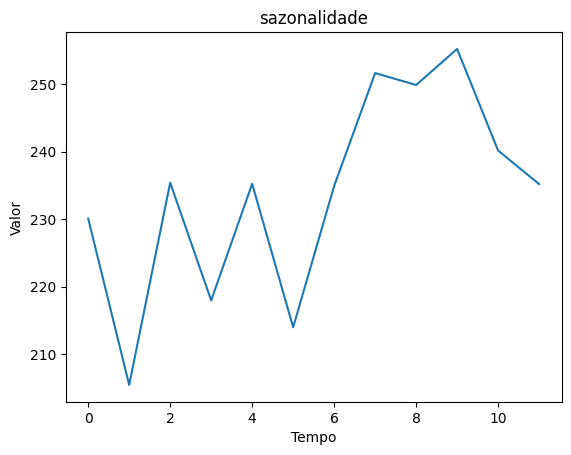

,sazonalidade
sazonalidade,
0,230.087867
1,205.444710
2,235.404026
3,217.965988
4,235.237966
5,213.983530
6,234.911641
7,251.641834
8,249.874753


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH Educacao,Bahia - IDH Longevidade,Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - IDH Renda,Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - PIB - Per Capita,Bahia - PIB - Preços de Mercado,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Bahia - Consumo de Cimento (t)
0,2003-1,0.299858,10915.348400,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.598394,0.766362,0.669899,39.798880,7.782609e+06,0.638715,1.317344e+08,8.384593e+06,8.566149,1.216359e+08,8.348779,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,230.087867,151.297
1,2003-2,0.301903,11028.218400,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.598795,0.766745,0.670210,39.480034,7.827094e+06,0.638948,1.318964e+08,8.391946e+06,8.569210,1.216914e+08,8.342979,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205.444710,138.707
2,2003-3,0.303709,11133.335807,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.599196,0.767127,0.670521,39.400256,7.871579e+06,0.639181,1.320584e+08,8.399299e+06,8.572270,1.217469e+08,8.337179,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,235.404026,135.009
3,2003-4,0.305311,11215.137236,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.599597,0.767509,0.670831,39.417185,7.916064e+06,0.639414,1.322204e+08,8.406652e+06,8.575331,1.218023e+08,8.331379,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,217.965988,126.554
4,2003-5,0.306860,11294.955512,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.599998,0.767892,0.671142,39.479943,7.960549e+06,0.639647,1.323824e+08,8.414005e+06,8.578392,1.218578e+08,8.325579,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,235.237966,137.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2002-8,NaN,NaN,1.608320,1010.371607,1488.966218,24.817842,20.666681,78.229336,1.977754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,235.237966,NaN
269,2002-9,NaN,NaN,1.453784,1009.628033,1569.704039,25.399925,20.932220,76.934612,2.093929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.983530,NaN
270,2002-10,NaN,NaN,1.071670,1008.927909,1667.519304,26.035253,21.204426,75.331548,2.191347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,234.911641,NaN
271,2002-11,NaN,NaN,1.149319,1008.388051,1694.210509,26.573861,21.523948,74.405966,2.307342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251.641834,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      139.997
1      111.865
2      159.603
3      142.063
4      137.144
        ...   
268        NaN
269        NaN
270        NaN
271        NaN
272        NaN
Name: Bahia - Consumo de Cimento (t), Length: 273, dtype: float64

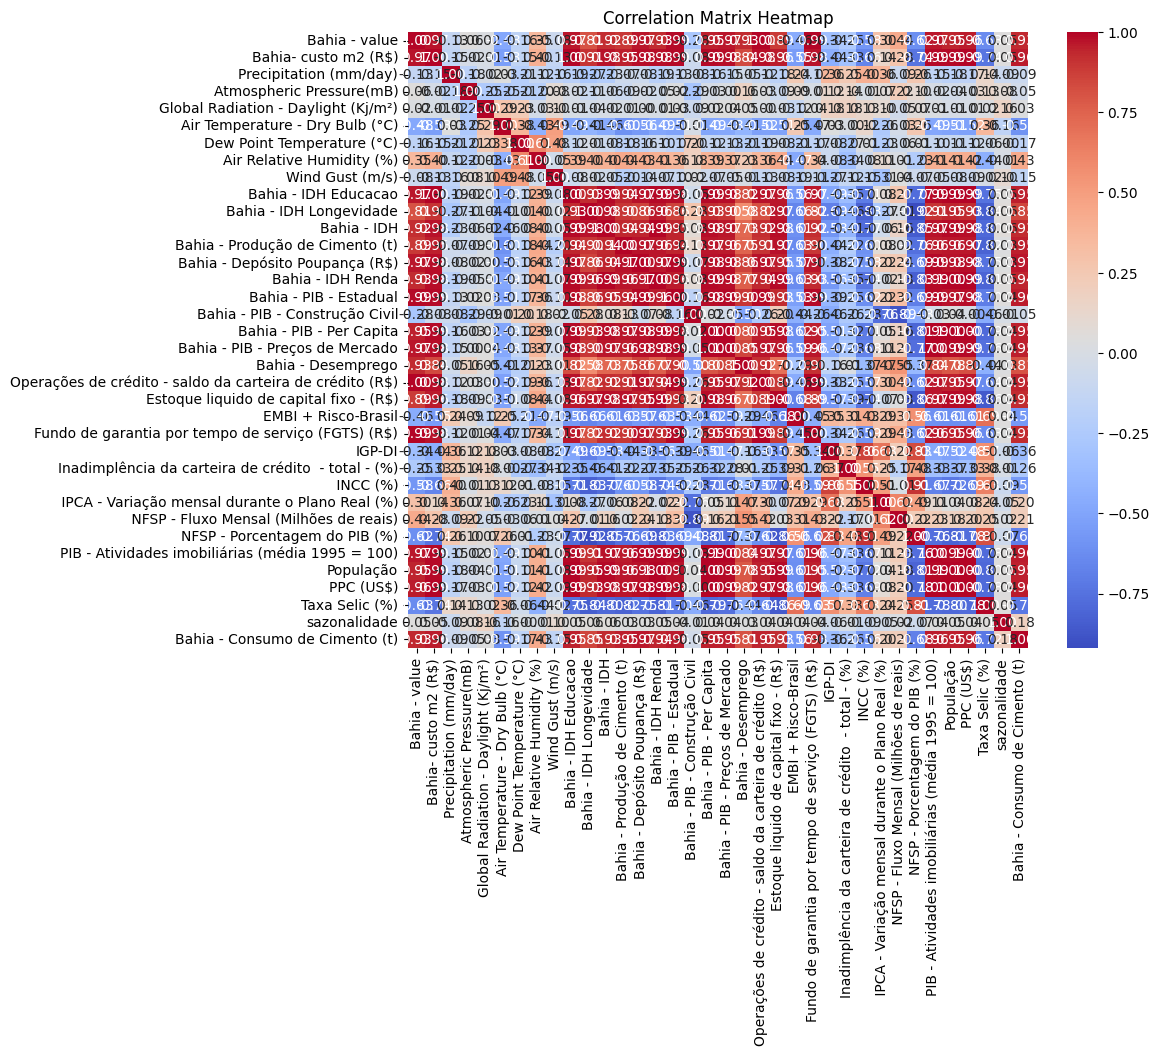

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Bahia - value,2.628760e+04
1,Bahia- custo m2 (R$),2.042333e+05
2,Precipitation (mm/day),7.552610e+00
3,Atmospheric Pressure(mB),1.261483e+01
4,Global Radiation - Daylight (Kj/m²),1.522354e+01
5,Air Temperature - Dry Bulb (°C),5.907549e+01
6,Dew Point Temperature (°C),1.153290e+02
7,Air Relative Humidity (%),1.658195e+02
8,Wind Gust (m/s),2.407675e+01
9,Bahia - IDH Educacao,6.970006e+10


In [39]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 6


,Bahia - value,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.299858,10915.348400,1.604227,1007.701639,1669.734463,26.973700,22.147525,75.411587,2.004234,0.669899,39.798880,7.782609e+06,1.317344e+08,8.384593e+06,8.348779,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,230.087867
1,0.301903,11028.218400,2.224533,1007.849476,1568.727444,26.728784,22.241910,76.966756,1.726139,0.670210,39.480034,7.827094e+06,1.318964e+08,8.391946e+06,8.342979,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,205.444710
2,0.303709,11133.335807,2.312330,1008.259608,1452.272884,26.305364,22.159668,78.493126,1.462602,0.670521,39.400256,7.871579e+06,1.320584e+08,8.399299e+06,8.337179,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,235.404026
3,0.305311,11215.137236,2.332765,1009.143887,1359.230366,25.788306,21.728601,78.801800,1.217048,0.670831,39.417185,7.916064e+06,1.322204e+08,8.406652e+06,8.331379,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,217.965988
4,0.306860,11294.955512,2.225842,1010.005569,1291.737281,25.189925,21.303605,79.547467,1.031926,0.671142,39.479943,7.960549e+06,1.323824e+08,8.414005e+06,8.325579,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,235.237966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.440098,22072.320867,0.953175,1010.251494,1410.249593,25.251963,20.545301,75.949584,1.571070,0.698458,100.859495,1.925276e+07,1.562551e+08,8.338494e+06,15.765701,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,1.969730e+08,390.589413,1.078474,251.641834
152,0.441017,22161.968084,0.881862,1009.694738,1527.696628,25.783602,20.741424,74.580756,1.588024,0.699141,100.608907,1.916621e+07,1.563148e+08,8.331099e+06,15.783009,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,1.970500e+08,391.798431,0.962516,249.874753
153,0.442032,22249.683487,1.004496,1008.999482,1542.749182,26.216909,21.089513,74.282786,1.597778,0.699823,100.334436,1.907966e+07,1.563744e+08,8.323703e+06,15.800317,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,1.971270e+08,393.032398,1.138989,255.217203
154,0.443045,22339.033891,1.092723,1008.484955,1601.055683,26.639846,21.398589,73.858925,1.571524,0.700505,99.775681,1.899311e+07,1.564341e+08,8.316308e+06,15.817625,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,1.972040e+08,394.326420,1.038436,240.163424


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.686392,-0.034500,-0.597577,1.209330,0.549454,-0.045689,-0.214165,1.222901,-2.171744,-1.494641,-1.403713,-1.564386,-1.659990,-0.670338,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617
1,-1.652728,1.139542,-0.510392,0.709099,0.351176,-0.016987,0.078484,0.396882,-2.130525,-1.506587,-1.393655,-1.543656,-1.599106,-0.672198,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013
2,-1.621375,1.305714,-0.268523,0.132366,0.008386,-0.041997,0.365714,-0.385892,-2.089306,-1.509576,-1.383596,-1.522925,-1.538222,-0.674058,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457
3,-1.596977,1.344390,0.252967,-0.328421,-0.410212,-0.173081,0.423800,-1.115256,-2.048087,-1.508942,-1.373538,-1.502194,-1.477337,-0.675918,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128
4,-1.573171,1.142019,0.761130,-0.662676,-0.894648,-0.302318,0.564118,-1.665116,-2.006868,-1.506591,-1.363480,-1.481463,-1.416453,-0.677778,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.641291,-1.266734,0.906160,-0.075752,-0.844423,-0.532913,-0.112926,-0.063714,1.617079,0.793052,1.189730,1.573297,-2.041690,1.708448,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.382734,1.398025,0.209123
152,1.668030,-1.401706,0.577823,0.505897,-0.414021,-0.473273,-0.370509,-0.013356,1.707594,0.783663,1.170161,1.580933,-2.102926,1.714000,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.395760,1.415152,-0.182135
153,1.694192,-1.169600,0.167806,0.580444,-0.063226,-0.367422,-0.426581,0.015618,1.798109,0.773380,1.150592,1.588569,-2.164162,1.719551,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.408786,1.432633,0.413308
154,1.720841,-1.002613,-0.135628,0.869203,0.279174,-0.273435,-0.506342,-0.062365,1.888623,0.752446,1.131023,1.596205,-2.225399,1.725102,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.421813,1.450965,0.074029


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-1.686392,-0.034500,-0.597577,1.209330,0.549454,-0.045689,-0.214165,1.222901,-2.171744,-1.494641,-1.403713,-1.564386,-1.659990,-0.670338,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617
1,-1.652728,1.139542,-0.510392,0.709099,0.351176,-0.016987,0.078484,0.396882,-2.130525,-1.506587,-1.393655,-1.543656,-1.599106,-0.672198,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013
2,-1.621375,1.305714,-0.268523,0.132366,0.008386,-0.041997,0.365714,-0.385892,-2.089306,-1.509576,-1.383596,-1.522925,-1.538222,-0.674058,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457
3,-1.596977,1.344390,0.252967,-0.328421,-0.410212,-0.173081,0.423800,-1.115256,-2.048087,-1.508942,-1.373538,-1.502194,-1.477337,-0.675918,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128
4,-1.573171,1.142019,0.761130,-0.662676,-0.894648,-0.302318,0.564118,-1.665116,-2.006868,-1.506591,-1.363480,-1.481463,-1.416453,-0.677778,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.327921,-0.603411,1.139890,-0.306229,-1.245354,-0.381740,0.728153,0.325738,0.984827,1.005041,1.397015,1.443085,-1.206500,1.597112,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.222749,1.245801,-0.282621
140,1.353857,-0.258763,0.762625,-0.071435,-1.019786,-0.342604,0.612356,0.349703,0.984557,0.988814,1.382955,1.458437,-1.287807,1.611608,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.236509,1.254608,-0.612121
141,1.380136,-0.394132,0.466611,0.305190,-0.683619,-0.312723,0.352513,0.297958,0.984287,0.972126,1.368895,1.473789,-1.369114,1.626104,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.250269,1.263636,-0.137902
142,1.406519,-0.115460,0.099554,0.450968,-0.371253,-0.251069,0.212127,0.111585,0.984017,0.954945,1.354835,1.489141,-1.450421,1.640599,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.264029,1.272935,-0.332143


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      139.997000
1      111.865000
2      159.603000
3      142.063000
4      137.144000
          ...    
139    294.008417
140    290.666932
141    296.762718
142    278.882942
143    273.056500
Name: Bahia - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 27)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Bahia- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Bahia - IDH,Bahia - Produção de Cimento (t),Bahia - Depósito Poupança (R$),Bahia - PIB - Estadual,Bahia - PIB - Construção Civil,Bahia - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
108,0.715141,-0.000021,-0.649297,1.038963,-0.171182,-0.259707,-0.039984,-0.034281,0.697308,1.124590,0.726709,0.751980,0.618874,0.999522,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.754385,0.812014,-1.082183
109,0.730732,0.457820,-0.501081,0.595089,-0.226590,-0.244146,0.063551,-0.021182,0.709769,1.140475,0.767601,0.779122,0.580030,1.021382,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.770574,0.831569,-1.036767
110,0.747043,0.432274,-0.167207,0.138516,-0.386770,-0.262433,0.176880,-0.123716,0.722230,1.159592,0.808493,0.806264,0.541186,1.043243,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.786763,0.850791,-0.752482
111,0.765233,0.398874,0.261978,-0.312763,-0.704982,-0.345963,0.269306,-0.147405,0.734690,1.167413,0.849384,0.833406,0.502341,1.065104,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.802953,0.868783,-1.088413
112,0.781807,0.535032,0.907265,-0.575745,-1.122961,-0.459055,0.374084,0.003822,0.747151,1.182520,0.890276,0.860548,0.463497,1.086965,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.819142,0.886720,-1.508135
113,0.798259,-0.126416,1.344034,-0.445159,-1.335689,-0.567118,0.279672,0.021200,0.759612,1.195782,0.931167,0.887690,0.424653,1.108826,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.835331,0.905151,-1.474280
114,0.814190,-0.334984,1.415346,-0.176978,-1.436264,-0.637268,0.180210,0.183596,0.772073,1.210529,0.972059,0.914832,0.385808,1.130686,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.851520,0.923702,-1.463452
115,0.829479,-0.610330,1.098484,0.019454,-1.288537,-0.589132,0.161594,0.325058,0.784534,1.218816,1.012951,0.941974,0.346964,1.152547,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.867709,0.942382,-1.236037
116,0.844573,-0.862060,0.520016,0.404206,-0.925707,-0.516971,0.004304,0.283718,0.796995,1.225144,1.053842,0.969116,0.308120,1.174408,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.883899,0.960385,-0.935721
117,0.859764,-0.760814,-0.042889,0.705349,-0.537010,-0.401751,-0.060519,0.265751,0.809455,1.232620,1.094734,0.996258,0.269276,1.196269,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.900088,0.977769,-1.241995


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 27)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3156839747, 2533470029, 2704523721, 1346208170, 663989104, 3676938256, 3829139310, 3513600748, 3361934940, 4047035676]


Step: 0 ___________________________________________
val_loss: 97.10401916503906
winner_seed: 3156839747


Step: 1 ___________________________________________
val_loss: 669.4318237304688


Step: 2 ___________________________________________
val_loss: 233.66793823242188


Step: 3 ___________________________________________
val_loss: 51.75699234008789
winner_seed: 1346208170


Step: 4 ___________________________________________
val_loss: 55.22538757324219


Step: 5 ___________________________________________
val_loss: 490.50469970703125


Step: 6 ___________________________________________
val_loss: 103.0590591430664


Step: 7 ___________________________________________
val_loss: 103.84521484375


Step: 8 ___________________________________________
val_loss: 159.11549377441406


Step: 9 ___________________________________________
val_loss: 436.2164611816406


final_see

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2536234443

Epoch 1/10000
4/4 [==============================] - 2s 131ms/step - loss: 70594.2422 - val_loss: 1285.0743
Epoch 2/10000
4/4 [==============================] - 0s 13ms/step - loss: 2489.6045 - val_loss: 2919.2195
Epoch 3/10000
4/4 [==============================] - 0s 12ms/step - loss: 4508.9463 - val_loss: 181.0214
Epoch 4/10000
4/4 [==============================] - 0s 12ms/step - loss: 2770.2419 - val_loss: 1475.1532
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 2367.2437 - val_loss: 357.9114
Epoch 6/10000
4/4 [==============================] - 0s 12ms/step - loss: 2939.9561 - val_loss: 1682.8312
Epoch 7/10000
4/4 [==============================] - 0s 12ms/step - loss: 2571.8457 - val_loss: 1111.7277
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 2789.7900 - val_loss: 3639.7788
Epoch 9/10000
4/4 [==============================] - 0s 13ms/step - loss: 3036.2664 - val_loss: 932.4382
Epoch 10/10000
4/4 [===========================

4/4 [==============================] - 0s 12ms/step - loss: 481.9420 - val_loss: 449.1788
Epoch 79/10000
4/4 [==============================] - 0s 12ms/step - loss: 858.2587 - val_loss: 571.3681
Epoch 80/10000
4/4 [==============================] - 0s 13ms/step - loss: 506.8103 - val_loss: 333.8909
Epoch 81/10000
4/4 [==============================] - 0s 12ms/step - loss: 461.9831 - val_loss: 271.6593
Epoch 82/10000
4/4 [==============================] - 0s 13ms/step - loss: 497.9247 - val_loss: 397.7378
Epoch 83/10000
4/4 [==============================] - 0s 13ms/step - loss: 481.2698 - val_loss: 451.7967
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 1041.5995 - val_loss: 425.4934
Epoch 85/10000
4/4 [==============================] - 0s 12ms/step - loss: 683.1948 - val_loss: 809.6922
Epoch 86/10000
4/4 [==============================] - 0s 12ms/step - loss: 590.6917 - val_loss: 593.2022
Epoch 87/10000
4/4 [==============================] - 0s 12ms/step - 

4/4 [==============================] - 0s 12ms/step - loss: 381.9694 - val_loss: 522.7041
Epoch 156/10000
4/4 [==============================] - 0s 13ms/step - loss: 367.8323 - val_loss: 453.0699
Epoch 157/10000
4/4 [==============================] - 0s 13ms/step - loss: 336.8152 - val_loss: 149.6798
Epoch 158/10000
4/4 [==============================] - 0s 12ms/step - loss: 335.1964 - val_loss: 146.5862
Epoch 159/10000
4/4 [==============================] - 0s 12ms/step - loss: 361.1995 - val_loss: 385.4752
Epoch 160/10000
4/4 [==============================] - 0s 14ms/step - loss: 343.6853 - val_loss: 154.2055
Epoch 161/10000
4/4 [==============================] - 0s 14ms/step - loss: 328.7536 - val_loss: 131.6533
Epoch 162/10000
4/4 [==============================] - 0s 12ms/step - loss: 428.0052 - val_loss: 171.9203
Epoch 163/10000
4/4 [==============================] - 0s 13ms/step - loss: 311.1348 - val_loss: 342.4746
Epoch 164/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 11ms/step - loss: 239.4755 - val_loss: 344.0618
Epoch 233/10000
4/4 [==============================] - 0s 11ms/step - loss: 251.2280 - val_loss: 217.2301
Epoch 234/10000
4/4 [==============================] - 0s 12ms/step - loss: 241.8188 - val_loss: 390.3332
Epoch 235/10000
4/4 [==============================] - 0s 11ms/step - loss: 277.1252 - val_loss: 364.2583
Epoch 236/10000
4/4 [==============================] - 0s 10ms/step - loss: 295.4753 - val_loss: 586.2899
Epoch 237/10000
4/4 [==============================] - 0s 10ms/step - loss: 308.4245 - val_loss: 241.6709
Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 261.8841 - val_loss: 297.5296
Epoch 239/10000
4/4 [==============================] - 0s 10ms/step - loss: 250.6373 - val_loss: 200.2651
Epoch 240/10000
4/4 [==============================] - 0s 10ms/step - loss: 267.5709 - val_loss: 218.4148
Epoch 241/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 11ms/step - loss: 190.2526 - val_loss: 508.4891
Epoch 310/10000
4/4 [==============================] - 0s 11ms/step - loss: 206.6116 - val_loss: 199.3874
Epoch 311/10000
4/4 [==============================] - 0s 11ms/step - loss: 206.3523 - val_loss: 292.3537
Epoch 312/10000
4/4 [==============================] - 0s 10ms/step - loss: 265.6992 - val_loss: 342.2388
Epoch 313/10000
4/4 [==============================] - 0s 11ms/step - loss: 208.0211 - val_loss: 194.3187
Epoch 314/10000
4/4 [==============================] - 0s 12ms/step - loss: 382.5642 - val_loss: 219.0238
Epoch 315/10000
4/4 [==============================] - 0s 12ms/step - loss: 291.1113 - val_loss: 320.0625
Epoch 316/10000
4/4 [==============================] - 0s 11ms/step - loss: 296.9140 - val_loss: 1274.7931
Epoch 317/10000
4/4 [==============================] - 0s 11ms/step - loss: 222.4087 - val_loss: 294.4274
Epoch 318/10000
4/4 [==============================] - 0s 11m

4/4 [==============================] - 0s 13ms/step - loss: 225.7820 - val_loss: 139.3795
Epoch 387/10000
4/4 [==============================] - 0s 13ms/step - loss: 175.1172 - val_loss: 299.4231
Epoch 388/10000
4/4 [==============================] - 0s 12ms/step - loss: 231.4229 - val_loss: 310.4864
Epoch 389/10000
4/4 [==============================] - 0s 13ms/step - loss: 226.7547 - val_loss: 175.1785
Epoch 390/10000
4/4 [==============================] - 0s 13ms/step - loss: 192.2377 - val_loss: 252.3795
Epoch 391/10000
4/4 [==============================] - 0s 13ms/step - loss: 225.8455 - val_loss: 171.7365
Epoch 392/10000
4/4 [==============================] - 0s 12ms/step - loss: 199.4976 - val_loss: 410.9871
Epoch 393/10000
4/4 [==============================] - 0s 12ms/step - loss: 207.2413 - val_loss: 274.3576
Epoch 394/10000
4/4 [==============================] - 0s 12ms/step - loss: 196.7184 - val_loss: 198.2381
Epoch 395/10000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 12ms/step - loss: 122.2931 - val_loss: 371.7122
Epoch 464/10000
4/4 [==============================] - 0s 12ms/step - loss: 135.9836 - val_loss: 144.6640
Epoch 465/10000
4/4 [==============================] - 0s 12ms/step - loss: 149.4538 - val_loss: 147.4557
Epoch 466/10000
4/4 [==============================] - 0s 12ms/step - loss: 134.6024 - val_loss: 242.6439
Epoch 467/10000
4/4 [==============================] - 0s 12ms/step - loss: 143.1097 - val_loss: 624.8972
Epoch 468/10000
4/4 [==============================] - 0s 12ms/step - loss: 181.9195 - val_loss: 610.9791
Epoch 469/10000
4/4 [==============================] - 0s 12ms/step - loss: 154.0691 - val_loss: 879.1141
Epoch 470/10000
4/4 [==============================] - 0s 12ms/step - loss: 158.5036 - val_loss: 698.7490
Epoch 471/10000
4/4 [==============================] - 0s 13ms/step - loss: 136.4470 - val_loss: 173.3078
Epoch 472/10000
4/4 [==============================] - 0s 12ms

4/4 [==============================] - 0s 12ms/step - loss: 309.8385 - val_loss: 950.1155
Epoch 541/10000
4/4 [==============================] - 0s 13ms/step - loss: 231.7645 - val_loss: 1404.3181
Epoch 542/10000
4/4 [==============================] - 0s 12ms/step - loss: 246.2712 - val_loss: 1018.4070
Epoch 543/10000
4/4 [==============================] - 0s 14ms/step - loss: 235.6162 - val_loss: 423.8659
Epoch 544/10000
4/4 [==============================] - 0s 11ms/step - loss: 198.3894 - val_loss: 331.9933
Epoch 545/10000
4/4 [==============================] - 0s 14ms/step - loss: 205.0071 - val_loss: 661.1214
Epoch 546/10000
4/4 [==============================] - 0s 13ms/step - loss: 179.7468 - val_loss: 427.6259
Epoch 547/10000
4/4 [==============================] - 0s 13ms/step - loss: 181.1276 - val_loss: 843.5956
Epoch 548/10000
4/4 [==============================] - 0s 13ms/step - loss: 174.3210 - val_loss: 572.4372
Epoch 549/10000
4/4 [==============================] - 0s 13

4/4 [==============================] - 0s 13ms/step - loss: 142.5329 - val_loss: 201.4405
Epoch 618/10000
4/4 [==============================] - 0s 11ms/step - loss: 149.4755 - val_loss: 196.0826
Epoch 619/10000
4/4 [==============================] - 0s 12ms/step - loss: 149.1579 - val_loss: 349.9920
Epoch 620/10000
4/4 [==============================] - 0s 12ms/step - loss: 163.6593 - val_loss: 374.8174
Epoch 621/10000
4/4 [==============================] - 0s 12ms/step - loss: 140.4211 - val_loss: 325.9908
Epoch 622/10000
4/4 [==============================] - 0s 13ms/step - loss: 130.7345 - val_loss: 998.9427
Epoch 623/10000
4/4 [==============================] - 0s 12ms/step - loss: 164.1230 - val_loss: 574.4581
Epoch 624/10000
4/4 [==============================] - 0s 14ms/step - loss: 166.5277 - val_loss: 1348.4628
Epoch 625/10000
4/4 [==============================] - 0s 13ms/step - loss: 208.9076 - val_loss: 279.8814
Epoch 626/10000
4/4 [==============================] - 0s 13m

4/4 [==============================] - 0s 12ms/step - loss: 118.2223 - val_loss: 68.9178
Epoch 695/10000
4/4 [==============================] - 0s 12ms/step - loss: 109.1452 - val_loss: 71.0999
Epoch 696/10000
4/4 [==============================] - 0s 12ms/step - loss: 110.8528 - val_loss: 248.8027
Epoch 697/10000
4/4 [==============================] - 0s 13ms/step - loss: 126.0424 - val_loss: 51.7570
Epoch 698/10000
4/4 [==============================] - 0s 13ms/step - loss: 109.1651 - val_loss: 113.4944
Epoch 699/10000
4/4 [==============================] - 0s 13ms/step - loss: 126.7010 - val_loss: 63.6232
Epoch 700/10000
4/4 [==============================] - 0s 12ms/step - loss: 95.1468 - val_loss: 68.1917
Epoch 701/10000
4/4 [==============================] - 0s 12ms/step - loss: 108.0995 - val_loss: 154.0180
Epoch 702/10000
4/4 [==============================] - 0s 12ms/step - loss: 129.5055 - val_loss: 78.9580
Epoch 703/10000
4/4 [==============================] - 0s 12ms/step -

Epoch 772/10000
4/4 [==============================] - 0s 13ms/step - loss: 61.2713 - val_loss: 102.8711
Epoch 773/10000
4/4 [==============================] - 0s 13ms/step - loss: 59.4875 - val_loss: 139.3464
Epoch 774/10000
4/4 [==============================] - 0s 13ms/step - loss: 74.5684 - val_loss: 128.3316
Epoch 775/10000
4/4 [==============================] - 0s 14ms/step - loss: 69.6154 - val_loss: 110.6595
Epoch 776/10000
4/4 [==============================] - 0s 13ms/step - loss: 64.4100 - val_loss: 103.2025
Epoch 777/10000
4/4 [==============================] - 0s 13ms/step - loss: 59.9138 - val_loss: 119.4174
Epoch 778/10000
4/4 [==============================] - 0s 12ms/step - loss: 66.4106 - val_loss: 170.2168
Epoch 779/10000
4/4 [==============================] - 0s 13ms/step - loss: 75.5281 - val_loss: 259.3915
Epoch 780/10000
4/4 [==============================] - 0s 12ms/step - loss: 83.8643 - val_loss: 199.8359
Epoch 781/10000
4/4 [==============================] - 

Epoch 850/10000
4/4 [==============================] - 0s 12ms/step - loss: 97.9812 - val_loss: 197.1535
Epoch 851/10000
4/4 [==============================] - 0s 12ms/step - loss: 82.4406 - val_loss: 170.4748
Epoch 852/10000
4/4 [==============================] - 0s 13ms/step - loss: 78.1573 - val_loss: 238.4859
Epoch 853/10000
4/4 [==============================] - 0s 13ms/step - loss: 99.4535 - val_loss: 145.1691
Epoch 854/10000
4/4 [==============================] - 0s 12ms/step - loss: 55.9786 - val_loss: 144.6607
Epoch 855/10000
4/4 [==============================] - 0s 13ms/step - loss: 57.6170 - val_loss: 130.0434
Epoch 856/10000
4/4 [==============================] - 0s 15ms/step - loss: 60.0366 - val_loss: 134.3662
Epoch 857/10000
4/4 [==============================] - 0s 13ms/step - loss: 59.4663 - val_loss: 134.6236
Epoch 858/10000
4/4 [==============================] - 0s 13ms/step - loss: 52.0531 - val_loss: 127.2544
Epoch 859/10000
4/4 [==============================] - 

Epoch 928/10000
4/4 [==============================] - 0s 14ms/step - loss: 115.6313 - val_loss: 4184.4600
Epoch 929/10000
4/4 [==============================] - 0s 13ms/step - loss: 377.3469 - val_loss: 2826.9424
Epoch 930/10000
4/4 [==============================] - 0s 12ms/step - loss: 287.3189 - val_loss: 742.9564
Epoch 931/10000
4/4 [==============================] - 0s 12ms/step - loss: 419.4122 - val_loss: 351.5466
Epoch 932/10000
4/4 [==============================] - 0s 13ms/step - loss: 654.2298 - val_loss: 520.3909
Epoch 933/10000
4/4 [==============================] - 0s 12ms/step - loss: 433.4538 - val_loss: 533.2369
Epoch 934/10000
4/4 [==============================] - 0s 13ms/step - loss: 209.6631 - val_loss: 539.4901
Epoch 935/10000
4/4 [==============================] - 0s 12ms/step - loss: 186.7272 - val_loss: 690.7350
Epoch 936/10000
4/4 [==============================] - 0s 14ms/step - loss: 241.6349 - val_loss: 249.7165
Epoch 937/10000
4/4 [=======================

4/4 [==============================] - 0s 12ms/step - loss: 122.0317 - val_loss: 227.7737
Epoch 1006/10000
4/4 [==============================] - 0s 12ms/step - loss: 121.6593 - val_loss: 197.2380
Epoch 1007/10000
4/4 [==============================] - 0s 13ms/step - loss: 93.9461 - val_loss: 175.8402
Epoch 1008/10000
4/4 [==============================] - 0s 13ms/step - loss: 92.2914 - val_loss: 694.3215
Epoch 1009/10000
4/4 [==============================] - 0s 13ms/step - loss: 160.1954 - val_loss: 165.0782
Epoch 1010/10000
4/4 [==============================] - 0s 12ms/step - loss: 120.0055 - val_loss: 143.0443
Epoch 1011/10000
4/4 [==============================] - 0s 13ms/step - loss: 101.5788 - val_loss: 147.3965
Epoch 1012/10000
4/4 [==============================] - 0s 12ms/step - loss: 97.4897 - val_loss: 169.8694
Epoch 1013/10000
4/4 [==============================] - 0s 13ms/step - loss: 93.7577 - val_loss: 154.9237
Epoch 1014/10000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 13ms/step - loss: 81.1301 - val_loss: 170.2608
Epoch 1083/10000
4/4 [==============================] - 0s 14ms/step - loss: 96.8769 - val_loss: 150.0776
Epoch 1084/10000
4/4 [==============================] - 0s 11ms/step - loss: 71.9813 - val_loss: 141.1440
Epoch 1085/10000
4/4 [==============================] - 0s 13ms/step - loss: 62.6550 - val_loss: 189.5851
Epoch 1086/10000
4/4 [==============================] - 0s 13ms/step - loss: 76.8101 - val_loss: 235.9788
Epoch 1087/10000
4/4 [==============================] - 0s 13ms/step - loss: 69.6708 - val_loss: 242.2744
Epoch 1088/10000
4/4 [==============================] - 0s 13ms/step - loss: 76.3827 - val_loss: 153.0966
Epoch 1089/10000
4/4 [==============================] - 0s 13ms/step - loss: 77.6321 - val_loss: 170.9143
Epoch 1090/10000
4/4 [==============================] - 0s 12ms/step - loss: 60.6238 - val_loss: 222.1546
Epoch 1091/10000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 13ms/step - loss: 44.8170 - val_loss: 176.1781
Epoch 1160/10000
4/4 [==============================] - 0s 13ms/step - loss: 71.5499 - val_loss: 132.2246
Epoch 1161/10000
4/4 [==============================] - 0s 13ms/step - loss: 52.0512 - val_loss: 132.1358
Epoch 1162/10000
4/4 [==============================] - 0s 14ms/step - loss: 56.8243 - val_loss: 192.8732
Epoch 1163/10000
4/4 [==============================] - 0s 12ms/step - loss: 66.8324 - val_loss: 125.2085
Epoch 1164/10000
4/4 [==============================] - 0s 13ms/step - loss: 51.6449 - val_loss: 119.5179
Epoch 1165/10000
4/4 [==============================] - 0s 12ms/step - loss: 60.6471 - val_loss: 132.2357
Epoch 1166/10000
4/4 [==============================] - 0s 13ms/step - loss: 51.0712 - val_loss: 111.2657
Epoch 1167/10000
4/4 [==============================] - 0s 10ms/step - loss: 59.8196 - val_loss: 169.8924
Epoch 1168/10000
4/4 [==============================] - 0s 12ms

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,264.650787,274.666138,272.771545,274.450745,283.431213,279.031036,279.344116,273.782318,265.606476,274.375122,265.189941,264.724457
Target,271.53,213.266,285.938,219.576,267.203,240.714,250.101,277.528,270.092,278.146,257.458,231.748
Error,6.879211,61.400131,13.166443,54.874741,16.22821,38.317032,29.243118,3.745697,4.485535,3.770874,7.731934,32.976456


In [54]:
display(mae)
display(mape)

22.73495

0.096835405

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 17ms/step
Ano-11: |Prediction[[3272.0237]] - Target[3063.3]| =  Error: [[208.72363]]; MAPE:[[0.06813686]]


[array([[208.72363]], dtype=float32)]

208.72363

0.068136856